## Binary Classification - SpamFilter (Larger Dataset)

-Saved as 'distilbert-base-uncased-SpamFilter-LG' on my HuggingFace profile

-Source for the Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

@article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}


#### Import Necessary Libraries

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import torch
from torch.nn.functional import cross_entropy
import torch.nn

from datasets import Dataset, DatasetDict

from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, set_seed

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Many Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Basic Constants/Values Used

In [3]:
model_ckpt = "distilbert-base-uncased"
device = "cpu"

max_input_len = 50
set_seed(42)

cpu


#### Ingest Data into Pandas DataFrame & Make Minor Edits to Data

In [4]:
data = pd.read_csv(r'/Users/briandunn/Documents/nlpnn/Datasets/SpamFilter (larger File)/spam.csv', engine='c')

data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
data.rename(columns={'v2' : 'text', 'v1' : 'label'}, inplace=True)
data.drop_duplicates(inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Visualize Message Length by 'label' Type

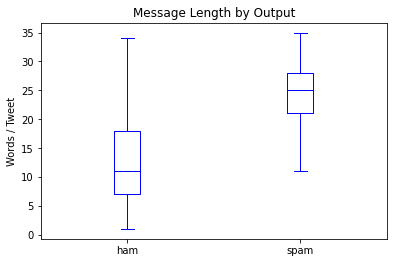

In [5]:
data['message_len'] = data['text'].str.split().apply(len)
data.boxplot("message_len", by="label", grid=False, showfliers=False, color="Blue")

plt.suptitle('')
plt.title('Message Length by Output')
plt.xlabel('')
plt.ylabel('Words / Tweet')
plt.show()

data = data.drop(columns=['message_len'])

#### Convert 'label' Feature from String to Numerical Value

In [6]:
data['label'].replace({'ham' : 0, 'spam' : 1}, inplace=True)

#### Convert Data from Pandas DataFrame to Dataset

In [7]:
dataset = Dataset.from_pandas(data)
dataset.shuffle(seed=42)
print(dataset)
print(dataset.features)

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 5158
})
{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Split Dataset into Train/Test/Valid Datasets

In [8]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print("Training dataset shape:", ds['train'].shape)
print("Validation dataset shape:", ds['valid'].shape)
print("Testing dataset shape:", ds['test'].shape)

Training dataset shape: (4126, 3)
Validation dataset shape: (516, 3)
Testing dataset shape: (516, 3)


#### Tokenize Entire Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len) 

encoded_data = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Sample to Ensure it Works as Expected

In [10]:
print(encoded_data['train'].column_names)
print(encoded_data['train'][240])

['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask']
{'label': 0, 'text': 'Ha... U jus ate honey ar? So sweet...', '__index_level_0__': 3664, 'input_ids': [101, 5292, 1012, 1012, 1012, 1057, 18414, 2015, 8823, 6861, 12098, 1029, 2061, 4086, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


#### Instantiate Model

In [11]:
num_labels=2
labels_dict = {0 : 'Non-Spam', 1 : 'Spam'}

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

#### Reminder to Enter HuggingFace Access Token; Make Sure That git lfs is Installed

In [12]:

# Used this the first time to install the git lfs; otherwise, it lets me know that git lfs has been initialized
!git lfs install

# Access Token ...

Git LFS initialized.


#### Create Compute_Metrics Function

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Instantiate TrainingArguments

In [15]:
batch_size=64
num_of_epochs=3
logging_steps = round(((len(ds['train']) / batch_size)), 0) // 2
model_name = f"{model_ckpt}-SpamFilter-LG"
learning_rate=2e-5

args = TrainingArguments(output_dir=model_name,
                         num_train_epochs=num_of_epochs,                          
                         per_device_train_batch_size=batch_size, 
                         per_device_eval_batch_size=batch_size, 
                         learning_rate=learning_rate,
                         weight_decay=0.01, 
                         evaluation_strategy="epoch", 
                         disable_tqdm=False,
                         push_to_hub=True, 
                         hub_strategy='every_save',
                         logging_steps=logging_steps,
                         log_level="error",
                         save_strategy='steps',
                         save_steps=logging_steps,
                         save_total_limit=12,
                         group_by_length=True)

#### Instantiate Optimizer (& Learning Rate Scheduler)

In [16]:
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(ds['train'])

lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer_name,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

optimizer = [optimizer_name, lr_scheduler]

#### Build Trainer

In [17]:
trainer = Trainer(model=model, 
                  args=args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  tokenizer=tokenizer, 
                  optimizers=optimizer)

/Users/briandunn/Documents/nlpnn/nlp_ch4/bin/distilbert-base-uncased-SpamFilter-LG is already a clone of https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-LG. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [18]:
trainer.train()

  0%|          | 0/195 [00:00<?, ?it/s]

{'loss': 0.2612, 'learning_rate': 1.9948295362740345e-05, 'epoch': 0.49}
{'loss': 0.0568, 'learning_rate': 1.9896590725480695e-05, 'epoch': 0.98}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.056810230016708374, 'eval_accuracy': 0.9786821705426356, 'eval_f1': 0.9791275964512537, 'eval_runtime': 54.1107, 'eval_samples_per_second': 9.536, 'eval_steps_per_second': 0.166, 'epoch': 1.0}
{'loss': 0.0294, 'learning_rate': 1.9844886088221038e-05, 'epoch': 1.48}
{'loss': 0.03, 'learning_rate': 1.9793181450961385e-05, 'epoch': 1.97}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.05329200252890587, 'eval_accuracy': 0.9806201550387597, 'eval_f1': 0.9810789657376363, 'eval_runtime': 53.7662, 'eval_samples_per_second': 9.597, 'eval_steps_per_second': 0.167, 'epoch': 2.0}
{'loss': 0.0151, 'learning_rate': 1.974147681370173e-05, 'epoch': 2.46}
{'loss': 0.0241, 'learning_rate': 1.9689772176442078e-05, 'epoch': 2.95}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.04997539520263672, 'eval_accuracy': 0.9844961240310077, 'eval_f1': 0.9847762068640159, 'eval_runtime': 53.9707, 'eval_samples_per_second': 9.561, 'eval_steps_per_second': 0.167, 'epoch': 3.0}
{'train_runtime': 4114.7674, 'train_samples_per_second': 3.008, 'train_steps_per_second': 0.047, 'train_loss': 0.0684305588595378, 'epoch': 3.0}


TrainOutput(global_step=195, training_loss=0.0684305588595378, metrics={'train_runtime': 4114.7674, 'train_samples_per_second': 3.008, 'train_steps_per_second': 0.047, 'train_loss': 0.0684305588595378, 'epoch': 3.0})

#### Inference Using Fine-Tuned Model

In [19]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/9 [00:00<?, ?it/s]

{'test_loss': 0.04997539520263672,
 'test_accuracy': 0.9844961240310077,
 'test_f1': 0.9847762068640159,
 'test_runtime': 53.9716,
 'test_samples_per_second': 9.561,
 'test_steps_per_second': 0.167}

#### Create Function to Calculate & Display Confusion Matrix

In [20]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Calculate Baseline for Confusion Matrix Calculations

In [21]:
num_labels=2

tokenizer2 = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128, return_tensors="np")

encoded_data = ds.map(tokenize, batched=True, batch_size=None)

model2 = (AutoModel.from_pretrained(model_ckpt, num_labels=num_labels, output_hidden_states=True).to(device))

def extract_hidden_states(batch=True):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model2(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

hidden_data = encoded_data.map(extract_hidden_states, batched=True)

X_train = np.array(hidden_data["train"]["hidden_state"])
X_valid = np.array(hidden_data["valid"]["hidden_state"])
y_train = np.array(hidden_data["train"]["label"])
y_valid = np.array(hidden_data["valid"]["label"])
X_train.shape, X_valid.shape

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

((4126, 768), (516, 768))

#### Plot Confusion Matrix

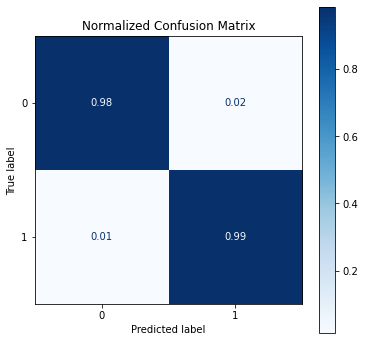

In [22]:
y_preds = np.argmax(output_predictions.predictions, axis=1)
labels = {0 : 'Non-Spam', 1 : 'Spam'}

plot_confusion_matrix(y_preds, y_valid, labels=labels)

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [23]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Aug29_14-18-14_Brians-Mac-mini/events.out.tfevents.1661800698.Brians-Mac-mini.11789.0: 100%|#…

To https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-LG
   8e28dcd..fe74b68  main -> main

To https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-LG
   fe74b68..d12176c  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-LG/commit/fe74b685e0f7616ae618c692625b5b8be2b41972'